In [1]:
!pip install emnist

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
from keras.layers import *
from keras.models import Model, load_model
from keras import backend as K
from keras import losses
from keras.optimizers import SGD
import imageio,os
from PIL import Image
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from emnist import extract_training_samples, extract_test_samples

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [45]:
batch_size = 100
latent_dim = 20
epochs = 100
img_dim = 28
filters = 16
intermediate_dim = 256
learning_rate = 0.01
momentum = 0.5
#dataset = 'balanced'
# dataset = 'letters'
dataset = 'mnist'
# dataset = 'fashion'

In [46]:
if dataset == 'balanced':
  num_classes = 47
  x_train, y_train = extract_training_samples(dataset)
  x_test, y_test = extract_test_samples(dataset)
elif dataset == 'letters':
  num_classes = 26
  x_train, y_train = extract_training_samples(dataset)
  x_test, y_test = extract_test_samples(dataset)
elif dataset == 'mnist':
  num_classes = 10
  from keras.datasets import mnist
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
elif dataset == 'fashion':
  num_classes = 10
  from keras.datasets import fashion_mnist as mnist
  (x_train, y_train), (x_test, y_test) = mnist.load_data()

In [47]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((-1, img_dim, img_dim, 1))
x_test = x_test.reshape((-1, img_dim, img_dim, 1))

In [48]:
#均匀分布encoder

x = Input(shape=(img_dim, img_dim, 1))
h = x

h = Conv2D(filters=filters, kernel_size=3, strides=2, padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Conv2D(filters=filters*2, kernel_size=3, strides=2, padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Conv2D(filters=filters*2, kernel_size=3, strides=1, padding='same')(h)
h = LeakyReLU(0.2)(h)

h_shape = K.int_shape(h)[1:]
h = Flatten()(h)
z_min = Dense(latent_dim)(h)  # 均匀分布的最小值
z_max = Dense(latent_dim)(h)  # 均匀分布的最大值

encoder = Model(x, [z_min, z_max])  # 通常认为 z_min 和 z_max 就是所需的隐变量编码


In [19]:
#beta分布encoder
x = Input(shape=(img_dim, img_dim, 1))
h = x

h = Conv2D(filters=filters, kernel_size=3, strides=2, padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Conv2D(filters=filters*2, kernel_size=3, strides=2, padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Conv2D(filters=filters*2, kernel_size=3, strides=1, padding='same')(h)
h = LeakyReLU(0.2)(h)

h_shape = K.int_shape(h)[1:]
h = Flatten()(h)
# 编码器输出均值和方差参数
z_mean = Dense(latent_dim)(h) # p(z|x)的均值
z_log_var = Dense(latent_dim)(h) # p(z|x)的方差


encoder = Model(x, z_mean) # 通常认为z_mean就是所需的隐变量编码

In [7]:
#高斯encoder
# 搭建模型

x = Input(shape=(img_dim, img_dim, 1))
h = x

h = Conv2D(filters=filters, kernel_size=3, strides=2, padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Conv2D(filters=filters*2, kernel_size=3, strides=2, padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Conv2D(filters=filters*2, kernel_size=3, strides=1, padding='same')(h)
h = LeakyReLU(0.2)(h)

h_shape = K.int_shape(h)[1:]
h = Flatten()(h)
z_mean = Dense(latent_dim)(h) # p(z|x)的均值
z_log_var = Dense(latent_dim)(h) # p(z|x)的方差

encoder = Model(x, z_mean) # 通常认为z_mean就是所需的隐变量编码

In [49]:
#均匀分布decoder

z = Input(shape=(latent_dim,))
h = z
h = Dense(np.prod(h_shape))(h)
h = Reshape(h_shape)(h)

# Mirroring VGG-5 based encoder structure
h = Conv2DTranspose(filters=filters*2, kernel_size=3, strides=1, padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Conv2DTranspose(filters=filters*2, kernel_size=3, strides=2, padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Conv2DTranspose(filters=filters, kernel_size=3, strides=1, padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Conv2DTranspose(filters=filters, kernel_size=3, strides=2, padding='same')(h)
h = LeakyReLU(0.2)(h)

x_recon = Conv2DTranspose(filters=1,
                           kernel_size=3,
                           activation='sigmoid',
                           padding='same')(h)

decoder = Model(z, x_recon)  # 解码器
generator = decoder



In [20]:
#beta分布decoder
z = Input(shape=(latent_dim,))
h = z
h = Dense(np.prod(h_shape))(h)
h = Reshape(h_shape)(h)

# Mirroring VGG-5 based encoder structure
h = Conv2DTranspose(filters=filters*2, kernel_size=3, strides=1, padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Conv2DTranspose(filters=filters*2, kernel_size=3, strides=2, padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Conv2DTranspose(filters=filters, kernel_size=3, strides=1, padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Conv2DTranspose(filters=filters, kernel_size=3, strides=2, padding='same')(h)
h = LeakyReLU(0.2)(h)

x_recon = Conv2DTranspose(filters=1,
              kernel_size=3,
              activation='sigmoid',
              padding='same')(h)


decoder = Model(z, x_recon) # 解码器
generator = decoder


In [8]:
#高斯decoder
z = Input(shape=(latent_dim,))
h = z
h = Dense(np.prod(h_shape))(h)
h = Reshape(h_shape)(h)

# Mirroring VGG-5 based encoder structure
h = Conv2DTranspose(filters=filters*2, kernel_size=3, strides=1, padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Conv2DTranspose(filters=filters*2, kernel_size=3, strides=2, padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Conv2DTranspose(filters=filters, kernel_size=3, strides=1, padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Conv2DTranspose(filters=filters, kernel_size=3, strides=2, padding='same')(h)
h = LeakyReLU(0.2)(h)

x_recon = Conv2DTranspose(filters=1,
              kernel_size=3,
              activation='sigmoid',
              padding='same')(h)


decoder = Model(z, x_recon) # 解码器
generator = decoder

In [50]:
#均匀分布的分类器
z = Input(shape=(latent_dim,))
y = Dense(intermediate_dim, activation='relu')(z)
y = Dense(num_classes, activation='sigmoid')(y)

classifier = Model(z, y)  # 隐变量分类器


In [21]:
#beta分布的分类器
z = Input(shape=(latent_dim,))
y = Dense(intermediate_dim, activation='relu')(z)
y = Dense(num_classes, activation='softmax')(y)
classifier = Model(z, y)

In [9]:
#高斯分布的分类器
z = Input(shape=(latent_dim,))
y = Dense(intermediate_dim, activation='relu')(z)
y = Dense(num_classes, activation='softmax')(y)

classifier = Model(z, y) # 隐变量分类器

In [51]:
from tensorflow.random import uniform
# import tensorflow_probability as tfp
from tensorflow.keras import backend as K

In [52]:
#均匀分布重参数

def sampling(args):
    z_min, z_max = args
    epsilon = uniform(shape=(K.shape(z_min)[0], latent_dim))
    return z_min + epsilon * (z_max - z_min)

# 重参数层，使用均匀分布采样
z = Lambda(sampling, output_shape=(latent_dim,))([z_min, z_max])
x_recon = decoder(z)
y = classifier(z)

In [22]:
#beta分布重参数
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
x_recon = decoder(z)
y = classifier(z)

In [10]:
#高斯分布重参数
# 重参数技巧
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(z_log_var / 2) * epsilon

# 重参数层，相当于给输入加入噪声
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
x_recon = decoder(z)
y = classifier(z)

In [53]:
#均匀分布的自定义层
class Uniform(Layer):
    """这是个简单的层，定义q(z|y)中的均匀分布参数，每个类别配一个范围。
    然后输出“z - 均值”，为后面计算loss准备。
    """
    def __init__(self, num_classes, **kwargs):
        self.num_classes = num_classes
        super(Uniform, self).__init__(**kwargs)

    def build(self, input_shape):
        latent_dim = input_shape[-1]
        self.min_val = self.add_weight(name='min_val',
                                       shape=(self.num_classes, latent_dim),
                                       initializer='zeros')
        self.max_val = self.add_weight(name='max_val',
                                       shape=(self.num_classes, latent_dim),
                                       initializer='ones')

    def call(self, inputs):
        z = inputs  # z.shape=(batch_size, latent_dim)
        z = K.expand_dims(z, 1)
        return z * (self.max_val - self.min_val) + self.min_val

    def compute_output_shape(self, input_shape):
        return (None, self.num_classes, input_shape[-1])

uniform_layer = Uniform(num_classes)
z_prior_uniform = uniform_layer(z)

In [23]:
#beta分布的自定义层
class Beta(Layer):

    def __init__(self, num_classes, **kwargs):
        self.num_classes = num_classes
        super(Beta, self).__init__(**kwargs)

    def build(self, input_shape):
        latent_dim = input_shape[-1]
        self.mean = self.add_weight(name='mean',
                       shape=(self.num_classes, latent_dim),
                       initializer='zeros')
    def call(self, inputs):
        z = inputs # z.shape=(batch_size, latent_dim)
        z = K.expand_dims(z, 1)
        return z - K.expand_dims(self.mean, 0)

    def compute_output_shape(self, input_shape):
        return (None, self.num_classes, input_shape[-1])

beta_layer = Beta(num_classes)
z_prior_beta = beta_layer(z)


In [11]:
#高斯分布的自定义层
class Gaussian(Layer):
    """这是个简单的层，定义q(z|y)中的均值参数，每个类别配一个均值。
    然后输出“z - 均值”，为后面计算loss准备。
    """
    def __init__(self, num_classes, **kwargs):
        self.num_classes = num_classes
        super(Gaussian, self).__init__(**kwargs)
    def build(self, input_shape):
        latent_dim = input_shape[-1]
        self.mean = self.add_weight(name='mean',
                       shape=(self.num_classes, latent_dim),
                       initializer='zeros')
    def call(self, inputs):
        z = inputs # z.shape=(batch_size, latent_dim)
        z = K.expand_dims(z, 1)
        return z - K.expand_dims(self.mean, 0)
    def compute_output_shape(self, input_shape):
        return (None, self.num_classes, input_shape[-1])

gaussian = Gaussian(num_classes)
z_prior_mean = gaussian(z)

In [54]:
#均匀分布的模型
vae = Model(x, [x_recon, z_prior_uniform, y])


In [24]:
#beta分布的模型
vae = Model(x, [x_recon, z_prior_beta, y])

In [12]:
#高斯分布的模型
vae = Model(x, [x_recon, z_prior_mean, y])

In [55]:
#均匀分布的loss
z_min = K.expand_dims(z_min, 1)
z_max = K.expand_dims(z_max, 1)

lamb = 1  # 重构误差的权重，它的相反数就是重构方差，越大意味着方差越小。
xent_loss = 0.5 * K.mean((x - x_recon)**2, 0)
# xent_loss = losses.binary_crossentropy(x, x_recon)
kl_loss = 0.5 * (z_max - z_min)**2
kl_loss = K.mean(kl_loss, 0)
cat_loss = K.mean(y * K.log(y + K.epsilon()), 0)
vae_loss = lamb * K.sum(xent_loss) + K.sum(kl_loss) + K.sum(cat_loss)

vae.add_loss(vae_loss)
optimizer = SGD(lr=learning_rate, momentum=momentum)
vae.compile(optimizer='adam')
vae.summary()


Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 14, 14, 16)           160       ['input_7[0][0]']             
                                                                                                  
 leaky_re_lu_16 (LeakyReLU)  (None, 14, 14, 16)           0         ['conv2d_8[0][0]']            
                                                                                                  
 conv2d_9 (Conv2D)           (None, 14, 14, 16)           2320      ['leaky_re_lu_16[0][0]']      
                                                                                           

 pLambda)                                                                                         
                                                                                                  
 tf.__operators__.add_7 (TF  ()                           0         ['tf.math.multiply_11[0][0]', 
 OpLambda)                                                           'tf.math.reduce_sum_7[0][0]']
                                                                                                  
 tf.math.reduce_sum_8 (TFOp  ()                           0         ['tf.math.reduce_mean_8[0][0]'
 Lambda)                                                            ]                             
                                                                                                  
 tf.__operators__.add_8 (TF  ()                           0         ['tf.__operators__.add_7[0][0]
 OpLambda)                                                          ',                            
          

In [25]:
#beta分布的loss
z_mean = K.expand_dims(z_mean, 1)
z_log_var = K.expand_dims(z_log_var, 1)

lamb = 1 # 这是重构误差的权重，它的相反数就是重构方差，越大意味着方差越小。
# 定义重构误差损失
xent_loss = 0.5 * K.mean((x - x_recon)**2, 0)
# xent_loss = binary_crossentropy(x, x_recon)
# 定义KL散度损失
kl_loss = -0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

# 定义分类损失
cat_loss = K.mean(y * K.log(y + K.epsilon()), 0)
# 定义总损失
vae_loss = lamb * K.sum(xent_loss) + K.sum(kl_loss) + K.sum(cat_loss)

# kl_loss = - 0.5 * (z_log_var - K.square(z_prior_beta))
# kl_loss = K.mean(K.batch_dot(K.expand_dims(y, 1), kl_loss), 0)
# cat_loss = K.mean(y * K.log(y + K.epsilon()), 0)
# vae_loss = lamb * K.sum(xent_loss) + K.sum(kl_loss) + K.sum(cat_loss)

# 添加损失到模型
vae.add_loss(vae_loss)
optimizer = SGD(lr=learning_rate, momentum=momentum)
vae.compile(optimizer=optimizer)
vae.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 14, 14, 16)           160       ['input_4[0][0]']             
                                                                                                  
 leaky_re_lu_8 (LeakyReLU)   (None, 14, 14, 16)           0         ['conv2d_4[0][0]']            
                                                                                                  
 conv2d_5 (Conv2D)           (None, 14, 14, 16)           2320      ['leaky_re_lu_8[0][0]']       
                                                                                            

 tf.math.multiply_6 (TFOpLa  (None, 10)                   0         ['model_6[0][0]',             
 mbda)                                                               'tf.math.log_1[0][0]']       
                                                                                                  
 tf.math.multiply_7 (TFOpLa  ()                           0         ['tf.math.reduce_sum_3[0][0]']
 mbda)                                                                                            
                                                                                                  
 tf.math.reduce_sum_4 (TFOp  ()                           0         ['tf.math.multiply_5[0][0]']  
 Lambda)                                                                                          
                                                                                                  
 tf.math.reduce_mean_5 (TFO  (10,)                        0         ['tf.math.multiply_6[0][0]']  
 pLambda) 

In [13]:
#高斯分布的loss
z_mean = K.expand_dims(z_mean, 1)
z_log_var = K.expand_dims(z_log_var, 1)

lamb = 1 # 这是重构误差的权重，它的相反数就是重构方差，越大意味着方差越小。
xent_loss = 0.5 * K.mean((x - x_recon)**2, 0)
#xent_loss = losses.binary_crossentropy(x, x_recon)
kl_loss = - 0.5 * (z_log_var - K.square(z_prior_mean))
kl_loss = K.mean(K.batch_dot(K.expand_dims(y, 1), kl_loss), 0)
cat_loss = K.mean(y * K.log(y + K.epsilon()), 0)
vae_loss = lamb * K.sum(xent_loss) + K.sum(kl_loss) + K.sum(cat_loss)


vae.add_loss(vae_loss)
optimizer = SGD(lr=learning_rate, momentum=momentum)
vae.compile(optimizer=optimizer)
vae.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 16)           160       ['input_1[0][0]']             
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 16)           0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 14, 14, 16)           2320      ['leaky_re_lu[0][0]']         
                                                                                            

 Lambda)                                                            ]                             
                                                                                                  
 tf.math.reduce_mean_2 (TFO  (10,)                        0         ['tf.math.multiply_2[0][0]']  
 pLambda)                                                                                         
                                                                                                  
 tf.__operators__.add_1 (TF  ()                           0         ['tf.math.multiply_3[0][0]',  
 OpLambda)                                                           'tf.math.reduce_sum_1[0][0]']
                                                                                                  
 tf.math.reduce_sum_2 (TFOp  ()                           0         ['tf.math.reduce_mean_2[0][0]'
 Lambda)                                                            ]                             
          

In [56]:
file_name = 'vae_vgg5_' + dataset + '_sgd_lr_' + str(learning_rate) + '_' + str(epochs) +'.h5'
print(file_name)

vae_vgg5_mnist_sgd_lr_0.01_100.h5


313/313 [==============================] - 2s 5ms/step


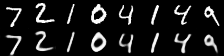

313/313 [==============================] - 2s 5ms/step


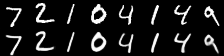

313/313 [==============================] - 2s 5ms/step


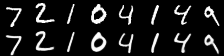

313/313 [==============================] - 2s 5ms/step


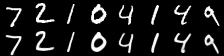

313/313 [==============================] - 2s 5ms/step


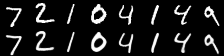

313/313 [==============================] - 2s 5ms/step


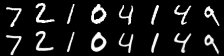

313/313 [==============================] - 2s 5ms/step


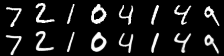

313/313 [==============================] - 2s 5ms/step


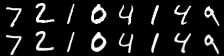

313/313 [==============================] - 2s 5ms/step


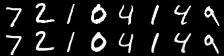

313/313 [==============================] - 2s 5ms/step


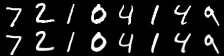

600/600 [==============================] - 34s 57ms/step - loss: -2.0004 - val_loss: -1.8991


In [57]:
if not os.path.exists('compare'):
    os.mkdir('compare')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
checkpoint_callback = ModelCheckpoint(
    filepath = file_name,  # 模型保存路径
    save_freq='epoch',  # 保存频率为每个epoch
    period=10  # 每隔10个epoch保存一次模型
)

callbacks = [early_stopping, reduce_lr]

for i in range(epochs):
  vae.fit(x_train,
      shuffle=True,
      epochs=1,
      batch_size=batch_size,
      validation_data=(x_test, None))#,
      #callbacks=callbacks)

  if i % 10 == 0:
    z_min_encoded, z_max_encoded = encoder.predict(x_test)
    z_encoded = sampling([z_min_encoded, z_max_encoded])
    recon = generator.predict(z_encoded)

#     x_test_encoded = encoder.predict(x_test)
#     recon = generator.predict(x_test_encoded)
    n = 8
    fig = np.zeros((img_dim * 2, img_dim * n))
    for m in range(n):
        x_test_origin = x_test[m].reshape((img_dim, img_dim))
        fig[0 * img_dim: (0 + 1) * img_dim,
            m * img_dim: (m + 1) * img_dim] = x_test_origin

        x_test_generate = recon[m].reshape((img_dim, img_dim))
        fig[1 * img_dim: (1 + 1) * img_dim,
            m * img_dim: (m + 1) * img_dim] = x_test_generate

        fit_path = './compare/epoch' + str(i) + '_compare.png'
        imageio.imwrite(fit_path,fig * 255)

    # 将numpy数组转换为PIL Image对象
    fig_pil = Image.fromarray((fig * 255).astype(np.uint8))

    # 显示图像
    display(fig_pil)

# 将模型保存到文件
vae.save(file_name)

In [58]:
max = K.eval(uniform_layer.max_val)
min = K.eval(uniform_layer.min_val)
means=0.5*(max-min)
# means = K.eval(beta_layer.mean)
# means = K.eval(gaussian.mean)
# means=K.eval(uniform_layer.max_val)
# x_train_encoded = encoder.predict(x_train)
x_train_encoded,x_train_encoded2=encoder.predict(x_train)
y_train_pred = classifier.predict(x_train_encoded).argmax(axis=1)
# x_test_encoded = encoder.predict(x_test)
x_test_encoded,x_test_encoded2=encoder.predict(x_test)
y_test_pred = classifier.predict(x_test_encoded).argmax(axis=1)

313/313 [==============================] - 0s 601us/step


In [59]:
def cluster_sample(path, category=0):
    """观察被模型聚为同一类的样本
    """
    n = 8
    figure = np.zeros((img_dim * n, img_dim * n))
    idxs = np.where(y_train_pred == category)[0]
    for i in range(n):
        for j in range(n):
            digit = x_train[np.random.choice(idxs)]
            digit = digit.reshape((img_dim, img_dim))
            figure[i * img_dim: (i + 1) * img_dim,
            j * img_dim: (j + 1) * img_dim] = digit
    imageio.imwrite(path, figure * 255)

In [60]:
def random_sample(path, category=0, std=1):
    """按照聚类结果进行条件随机生成
    """
    n = 8
    figure = np.zeros((img_dim * n, img_dim * n))
    for i in range(n):
        for j in range(n):
            noise_shape = (1, latent_dim)
            z_sample = np.array(np.random.randn(*noise_shape)) * std + means[category]
            x_recon = generator.predict(z_sample)
            digit = x_recon[0].reshape((img_dim, img_dim))
            figure[i * img_dim: (i + 1) * img_dim,
            j * img_dim: (j + 1) * img_dim] = digit
    imageio.imwrite(path, figure * 255)

In [61]:
if not os.path.exists('samples'):
    os.mkdir('samples')

for i in range(10):
    cluster_sample(u'samples/聚类类别_%s.png' % i, i)
    random_sample(u'samples/类别采样_%s.png' % i, i)

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


In [62]:
right = 0.
for i in range(10):
    _ = np.bincount(y_train[y_train_pred == i])
    right += _.max()

print (f'train acc: {right / len(y_train)}')


right = 0.
for i in range(10):
    _ = np.bincount(y_test[y_test_pred == i])
    right += _.max()

print (f'test acc: {right / len(y_test)}')

train acc: 0.27618333333333334
test acc: 0.2861
